In [180]:
import glob
import os.path as op
from itertools import compress
import numpy as np
from matplotlib import gridspec
import matplotlib.pylab as plt
from utilities import files, tools
import scipy.ndimage.filters as nd
from scipy.interpolate import interp1d
import math

In [120]:
def items_cont_str(input_list, string, sort=False):
    """
    returns a list of items which contain a given string
    optionally sorted
    """
    output_list = [string in i for i in input_list]
    output_list = list(compress(input_list, output_list))
    if sort:
        output_list.sort()
    return output_list

def to_polar(x, y):
    radius = []
    angle = []
    xy = zip(x, y)
    for x, y in xy:
        rad, theta = tools.cart2polar(x, y)
        theta = math.degrees(theta)
        angle.append(theta)
        radius.append(rad)
    del xy
    radius = np.array(radius)
    angle = np.array(angle)
    return [angle, radius]

def nan_cleaner(arr):
    """
    clears nan values and interpolates the missing value
    """
    mask = np.isnan(arr)
    arr[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), arr[~mask])
    return arr


def calculate_degs(angle, radius):
    degs = np.diff(angle)
    degs = np.insert(degs, 0, 0)
    degs[np.abs(degs) > 300] = np.nan
    degs = nan_cleaner(degs)
    degs = degs * radius
    return degs

def resamp_interp(x, y, new_x):
    """
    returns resampled an interpolated data
    """
    resamp = interp1d(x, y, kind='slinear', fill_value='extrapolate')
    new_data = resamp(new_x)
    return new_data

0.26871657754010697


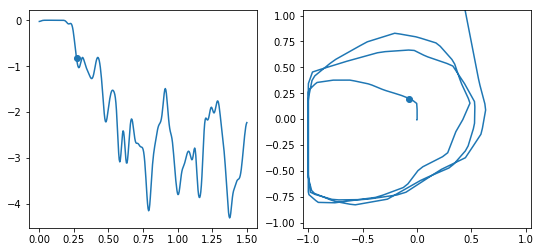

In [187]:
glob_path = op.join("data", "**", "*.npy")
all_pkl = [i for i in glob.iglob(glob_path, recursive=True)]
all_npy_files = items_cont_str(all_pkl, ".npy", sort=True)
file = all_npy_files[4]
joy_data = np.load(file)
x, y, t = joy_data
t = t - t[0]

time = np.linspace(0.0, 1.5, num=375)

x_interp = resamp_interp(t, x, time)
y_interp = resamp_interp(t, y, time)

for i in [[x_interp, y_interp, time]]:
    angle, radius = to_polar(i[0], i[1])
    ix = np.where(radius>0.2)[0][0]
    degs = calculate_degs(angle, radius)
    degs = nd.gaussian_filter1d(degs, sigma=3)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    fig = plt.figure(figsize=(9, 4))
    ax1 = plt.subplot(gs[0])
    ax1.plot(i[2], degs)
    ax1.scatter(i[2][ix], degs[ix])
    print(i[2][ix])
    ax2 = plt.subplot(gs[1])
    ax2.plot(i[1], i[0])
    ax2.scatter(i[1][ix], i[0][ix])
    plt.xlim([-1.05,1.05])
    plt.ylim([-1.05,1.05])